# Import important libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.applications.vgg19 import VGG19
import seaborn as sns

In [4]:
import pathlib
path = "./cell_images"
data_dir = pathlib.Path(path).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [6]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of uninfected cells", len(parasitized))

Number of uninfected cells 13780
Number of uninfected cells 13780


# Displaying some examples

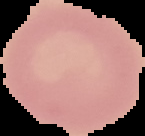

In [7]:
PIL.Image.open(uninfected[1])

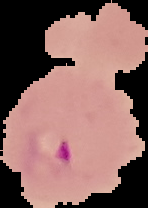

In [8]:
PIL.Image.open(parasitized[1])

In [9]:
batch_size = 32
img_height = 150
img_width = 150

In [10]:
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [11]:
training_data = image_gen.flow_from_directory(
    data_dir,
    subset = "training",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    subset = "validation",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


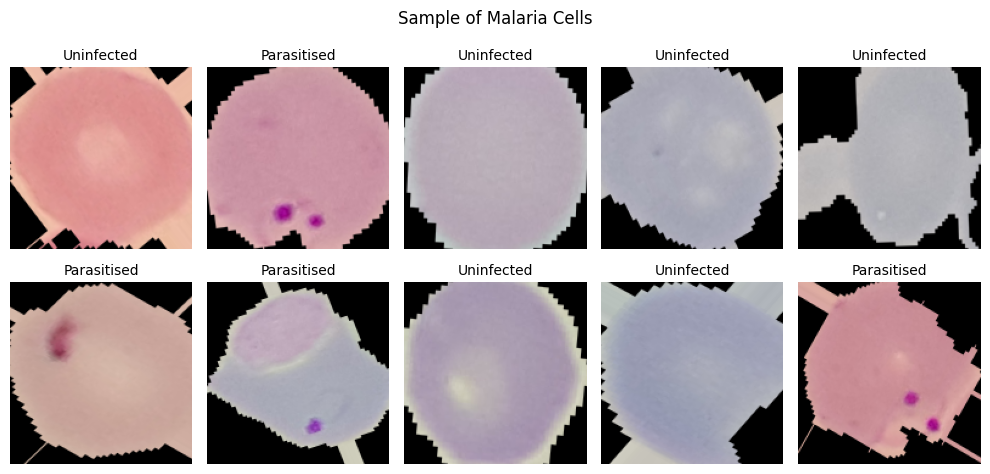

In [12]:
X_train, y_train = next(training_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i])
    ax.axis("off")
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()

# Building 'Home-Made' Network

## Our model Architecture

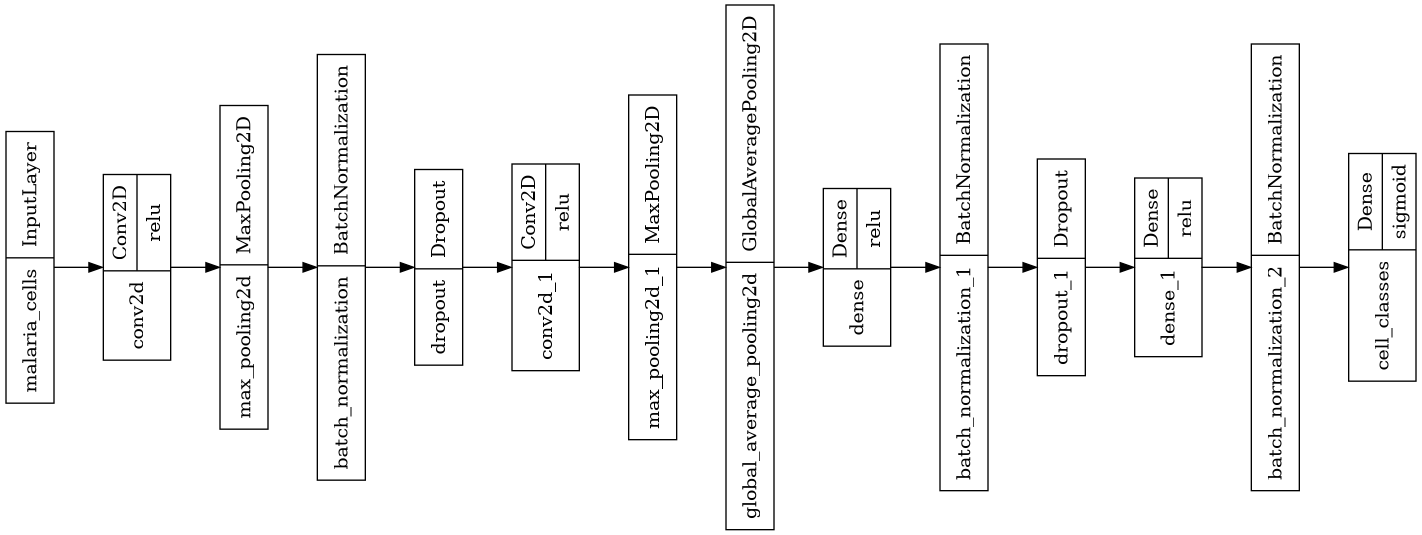

In [13]:
input = Input(shape = (img_width, img_height, 3), dtype=tf.float32, name="malaria_cells")
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(input)
X = MaxPooling2D(pool_size = (2, 2))(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(X)
X = MaxPooling2D(pool_size = (2, 2))(X)

X = GlobalAveragePooling2D()(X)
X = Dense(512, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model = Model(inputs=input, outputs=output)

In [14]:
plot_model(model, "model.png", show_layer_activations=True)
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cell_classes (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,913 (808.25 KB)

 Trainable params: 205,249 (801.75 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [15]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

## Training our model

In [16]:
epochs = 5

checkpoint_filepath = '/tmp/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3, restore_best_weights=True)

history = model.fit(training_data, epochs=epochs, validation_data=validation_data, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/5


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 1066s 2s/step - accuracy: 0.6701 - loss: 0.6431 - val_accuracy: 0.8340 - val_loss: 0.4431
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.9154 - loss: 0.2559 - val_accuracy: 0.9192 - val_loss: 0.3365
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.9318 - loss: 0.2150 - val_accuracy: 0.9395 - val_loss: 0.2018
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 380s 627ms/step - accuracy: 0.9403 - loss: 0.1955 - val_accuracy: 0.9414 - val_loss: 0.1775
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 419s 693ms/step - accuracy: 0.9432 - loss: 0.1870 - val_accuracy: 0.9489 - val_loss: 0.2386


In [17]:
model.save("malaria-cnn-v1.keras")

In [18]:
model.evaluate(validation_data)

259/259 ━━━━━━━━━━━━━━━━━━━━ 59s 226ms/step - accuracy: 0.9416 - loss: 0.1764


[0.1764100193977356, 0.9438664317131042]

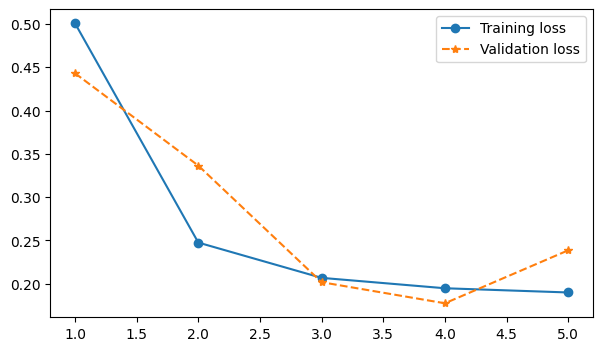

In [19]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

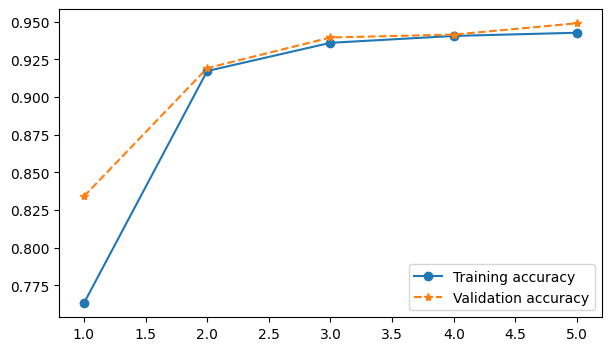

In [20]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

In [21]:
y_pred_proba = model.predict(validation_data).flatten()
y_pred_classes = (y_pred_proba >= 0.5).astype(np.int32)

259/259 ━━━━━━━━━━━━━━━━━━━━ 58s 222ms/step


In [22]:
def evaluate_ramdom_image(path, ax):
    image = load_img(str(path), target_size=(img_width, img_height))
    img_arr = img_to_array(image)
    img_arr /= 255
    pred = model.predict(img_arr.reshape(1, *img_arr.shape), verbose=0).flatten()
    label = "Parasitised" if pred < 0.5 else "Uninfected"
    ax.imshow(img_arr, vmin=1, vmax=1)
    ax.set_title(f"{label} - {pred[0]:.2%}", size=10)
    ax.axis("off")
    # plt.show()

In [23]:
parasitized_path = list(data_dir.glob("Parasitized/*"))
uninfected_path = list(data_dir.glob("Uninfected/*"))

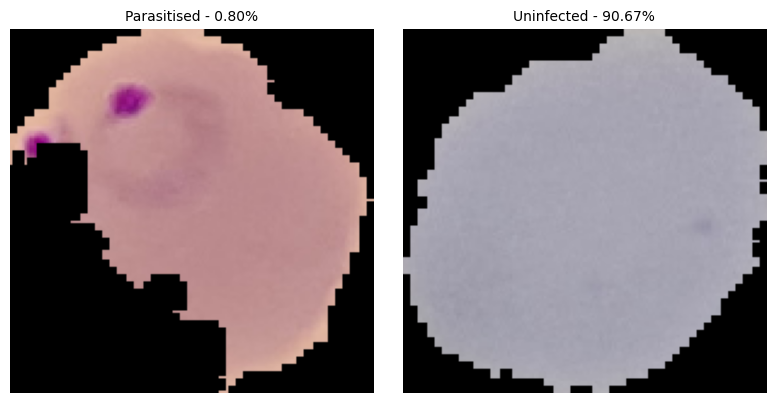

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
index = np.random.randint(len(parasitized_path))
evaluate_ramdom_image(parasitized_path[index], ax1)
evaluate_ramdom_image(uninfected_path[index], ax2)
plt.tight_layout()

---
# Using Transfer Learning -- VGG19

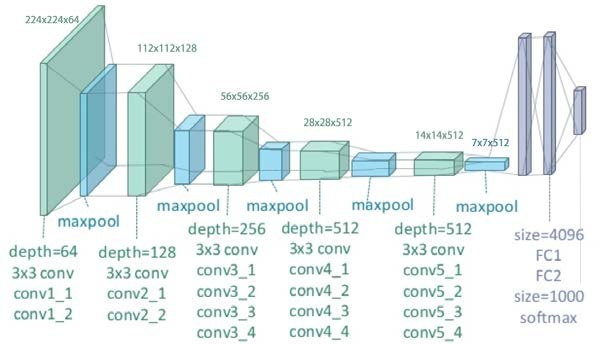

Source: [researchgate](https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356)

In [25]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [26]:
input = Input(shape=(img_width, img_height, 3), dtype=tf.float32)
vgg_model = base_model(input)
X = Flatten()(vgg_model)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model_2 = Model(inputs=input, outputs=output)
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cell_classes (Dense)            │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,032,577 (76.42 MB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [27]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model_2.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [28]:
epochs = 5
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3, restore_best_weights=True)

history = model_2.fit(training_data, epochs=epochs, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 2460s 4s/step - accuracy: 0.7969 - loss: 0.4291 - val_accuracy: 0.8703 - val_loss: 0.3311
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1862s 3s/step - accuracy: 0.8982 - loss: 0.2644 - val_accuracy: 0.8591 - val_loss: 0.3348
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1897s 3s/step - accuracy: 0.9085 - loss: 0.2386 - val_accuracy: 0.8909 - val_loss: 0.2996
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1848s 3s/step - accuracy: 0.9108 - loss: 0.2304 - val_accuracy: 0.8995 - val_loss: 0.2657
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 1790s 3s/step - accuracy: 0.9163 - loss: 0.2264 - val_accuracy: 0.9009 - val_loss: 0.2600


In [ ]:
model_2.evaluate(validation_data)

Logistic regression

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:


# Define transformations for the test set
transforms = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])



In [4]:
# Load the entire dataset
image_dir = "./cell_images"
full_dataset = datasets.ImageFolder(image_dir)

# Split the dataset into train and test sets
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

# Create subsets for train and test
train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

# Apply transformations to train and test subsets
train_subset.dataset.transform = transforms
test_subset.dataset.transform = transforms

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

# Check the number of images in train and test sets
print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

Number of images in train set: 22046
Number of images in test set: 5512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


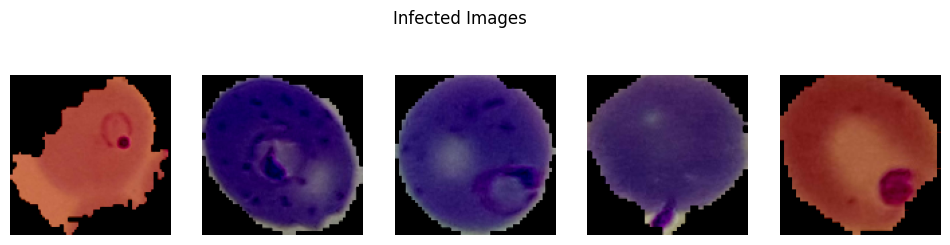

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


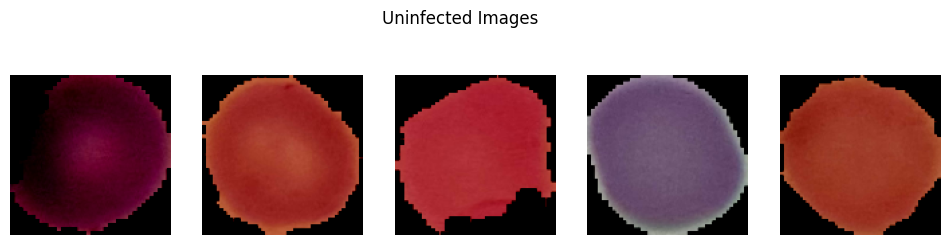

In [5]:
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Define classes
classes = ['infected', 'uninfected']

# Function to get a batch of images from the loader
def get_batch(loader, class_index, num_images):
    for batch, labels in loader:
        images = batch[labels == class_index][:num_images]
        return images

# Get five images of infected class
infected_images = get_batch(train_loader, class_index=0, num_images=5)
show_images(infected_images, 'Infected Images')

# Get five images of uninfected class
uninfected_images = get_batch(train_loader, class_index=1, num_images=5)
show_images(uninfected_images, 'Uninfected Images')

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)

In [7]:

input_size = 120 * 120 * 3
num_classes = 2
num_epochs = 30
best_test_accuracy = 0.0
early_stopping_patience = 6
early_stopping_counter = 0

# Initialize the model
model = LogisticRegressionModel(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = StepLR(optimizer,step_size=3, gamma=0.5)

# Training the model


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy, test_accuracy))

    scheduler.step()

    # Early stopping
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print('Early stopping at epoch', epoch+1)
            break

print('Finished Training')

# Evaluation using scikit-learn metrics
model.eval()
true_labels = []
predicted_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        predicted_probabilities.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

predicted_labels = np.argmax(predicted_probabilities, axis=1)

Epoch [1/30], Train Loss: 0.6186, Train Accuracy: 66.67%, Test Accuracy: 67.87%
Epoch [2/30], Train Loss: 0.6019, Train Accuracy: 68.28%, Test Accuracy: 68.07%
Epoch [3/30], Train Loss: 0.5974, Train Accuracy: 68.72%, Test Accuracy: 66.67%
Epoch [4/30], Train Loss: 0.5883, Train Accuracy: 69.45%, Test Accuracy: 68.70%
Epoch [5/30], Train Loss: 0.5864, Train Accuracy: 69.70%, Test Accuracy: 68.83%
Epoch [6/30], Train Loss: 0.5836, Train Accuracy: 70.06%, Test Accuracy: 67.82%
Epoch [7/30], Train Loss: 0.5790, Train Accuracy: 70.46%, Test Accuracy: 68.94%
Epoch [8/30], Train Loss: 0.5779, Train Accuracy: 70.48%, Test Accuracy: 69.12%
Epoch [9/30], Train Loss: 0.5771, Train Accuracy: 70.39%, Test Accuracy: 68.78%
Epoch [10/30], Train Loss: 0.5747, Train Accuracy: 70.85%, Test Accuracy: 68.96%
Epoch [11/30], Train Loss: 0.5745, Train Accuracy: 70.65%, Test Accuracy: 69.10%
Epoch [12/30], Train Loss: 0.5736, Train Accuracy: 70.95%, Test Accuracy: 69.10%
Epoch [13/30], Train Loss: 0.5725, Tr

In [8]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.6895863570391872


In [9]:
print('Classification Report:')
print(classification_report(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2797
           1       0.69      0.66      0.68      2715

    accuracy                           0.69      5512
   macro avg       0.69      0.69      0.69      5512
weighted avg       0.69      0.69      0.69      5512



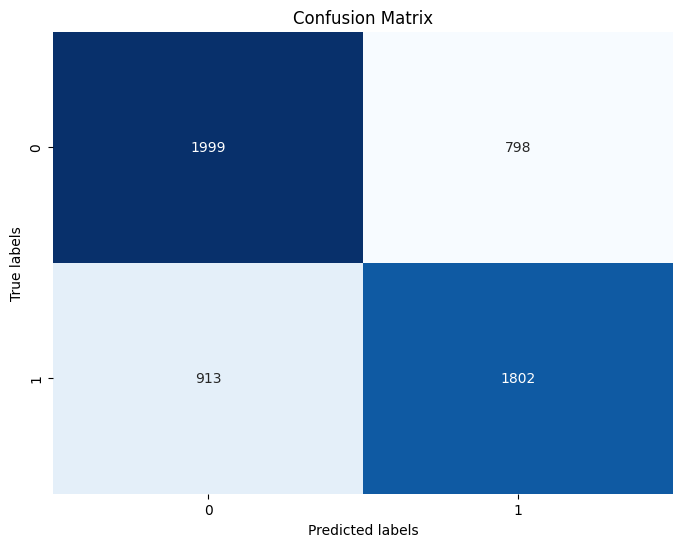

In [10]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()